C:\Users\munky\AppData\Local\Temp\ipykernel_19684\118341065.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('data_banda.txt', delim_whitespace=True, parse_dates=['Date'], dayfirst=True)


Date      datetime64[ns]
SST              float64
SSS              float64
NO3              float64
PO4              float64
Si               float64
Fe               float64
Chl-a            float64
Oxygen           float64
SPCO2            float64
dtype: object


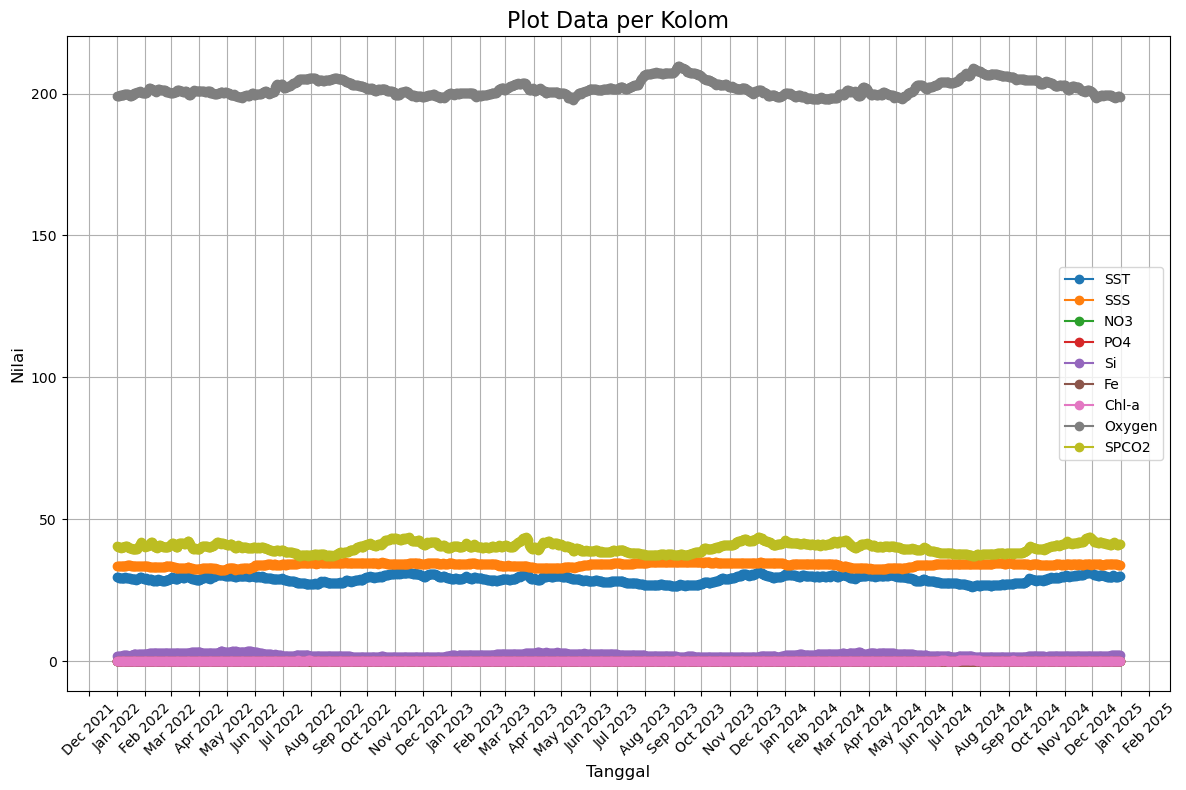

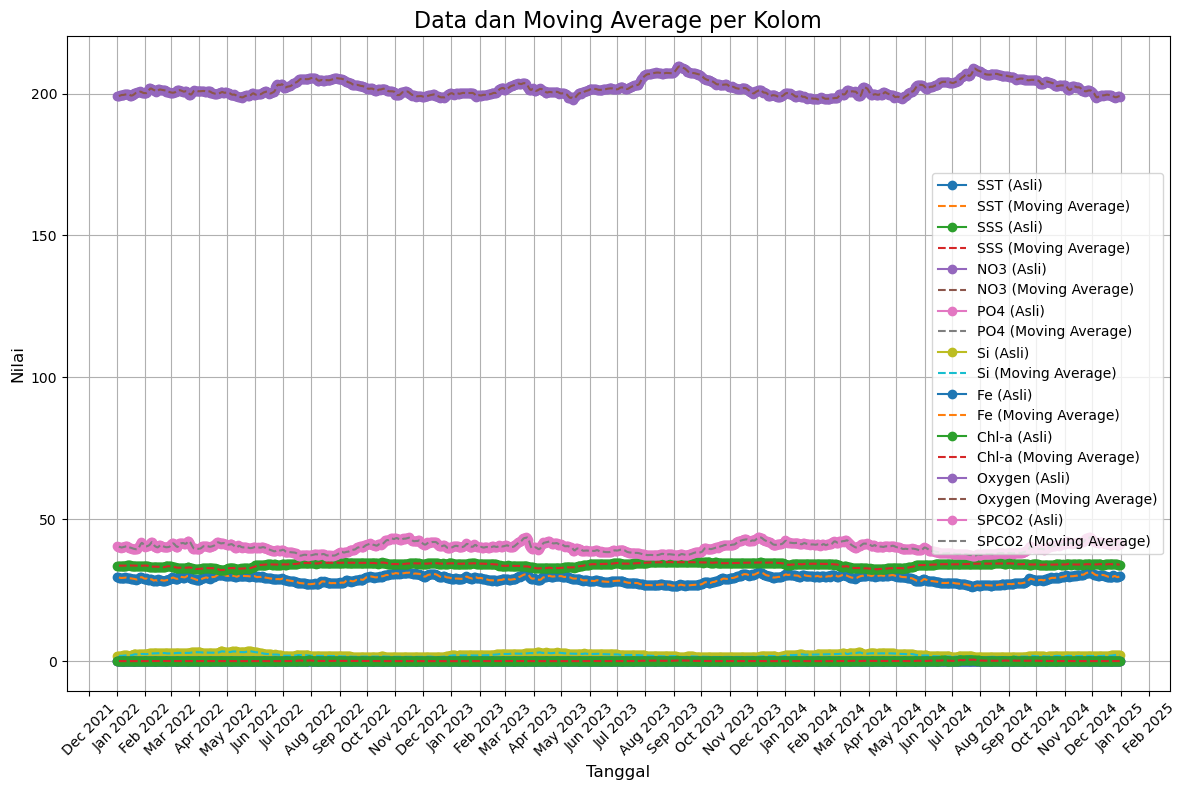

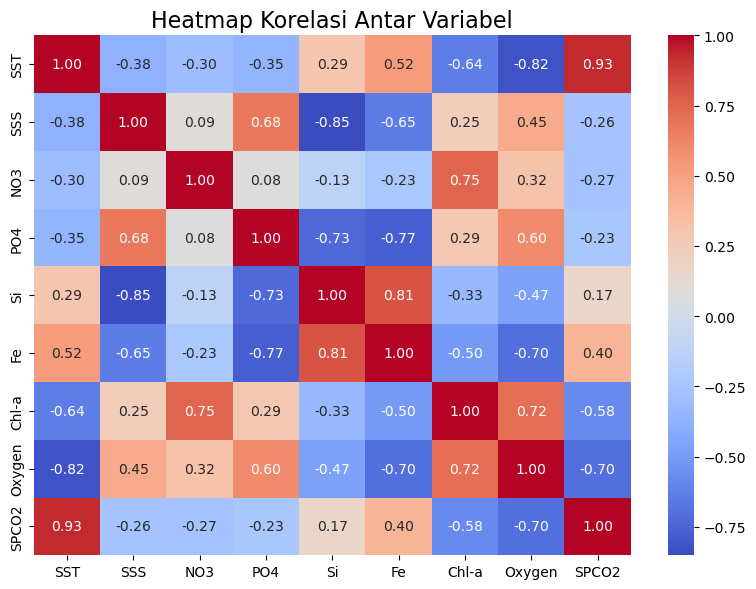

           PC1       PC2       Date
0    -1.226205 -0.418568 2022-01-01
1    -1.201114 -0.417861 2022-01-02
2    -1.158600 -0.374933 2022-01-03
3    -1.005147 -0.308022 2022-01-04
4    -0.963815 -0.252573 2022-01-05
...        ...       ...        ...
1091 -1.748221 -0.333517 2024-12-27
1092 -1.621870 -0.351092 2024-12-28
1093 -1.506331 -0.405391 2024-12-29
1094 -1.534738 -0.537999 2024-12-30
1095 -1.542198 -0.514828 2024-12-31

[1096 rows x 3 columns]


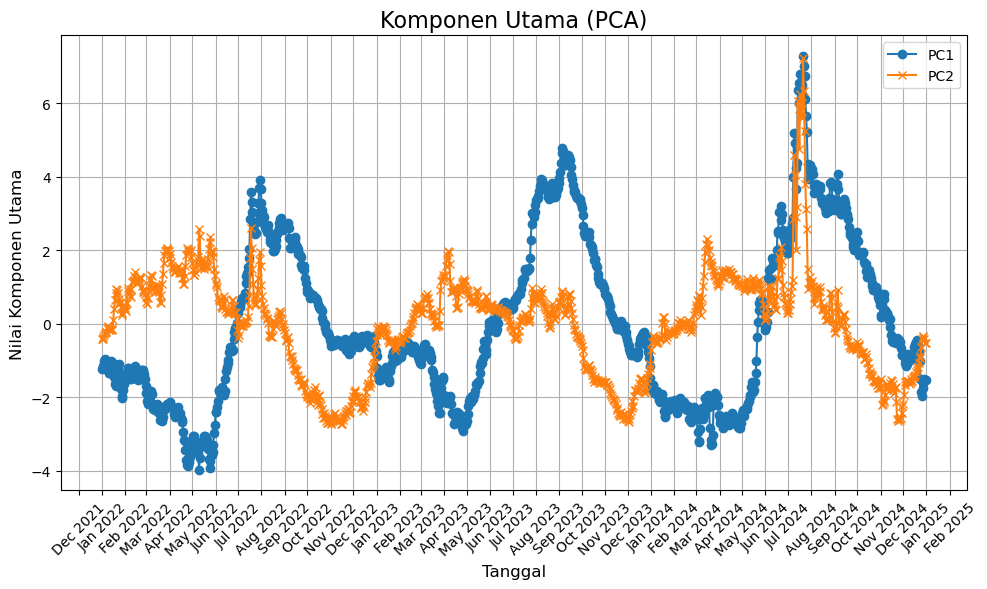

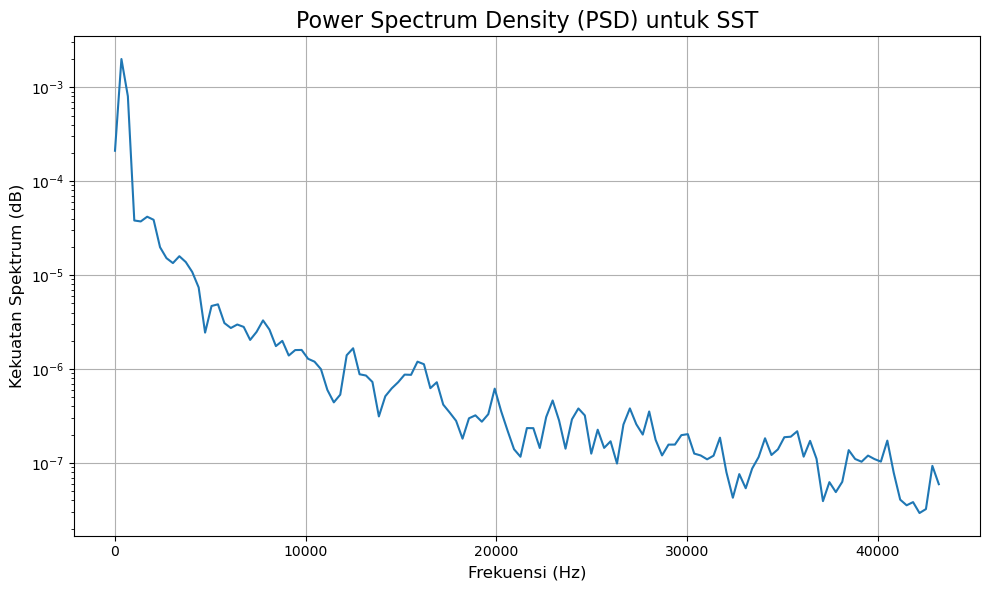

C:\Users\munky\miniconda3\envs\ocean\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


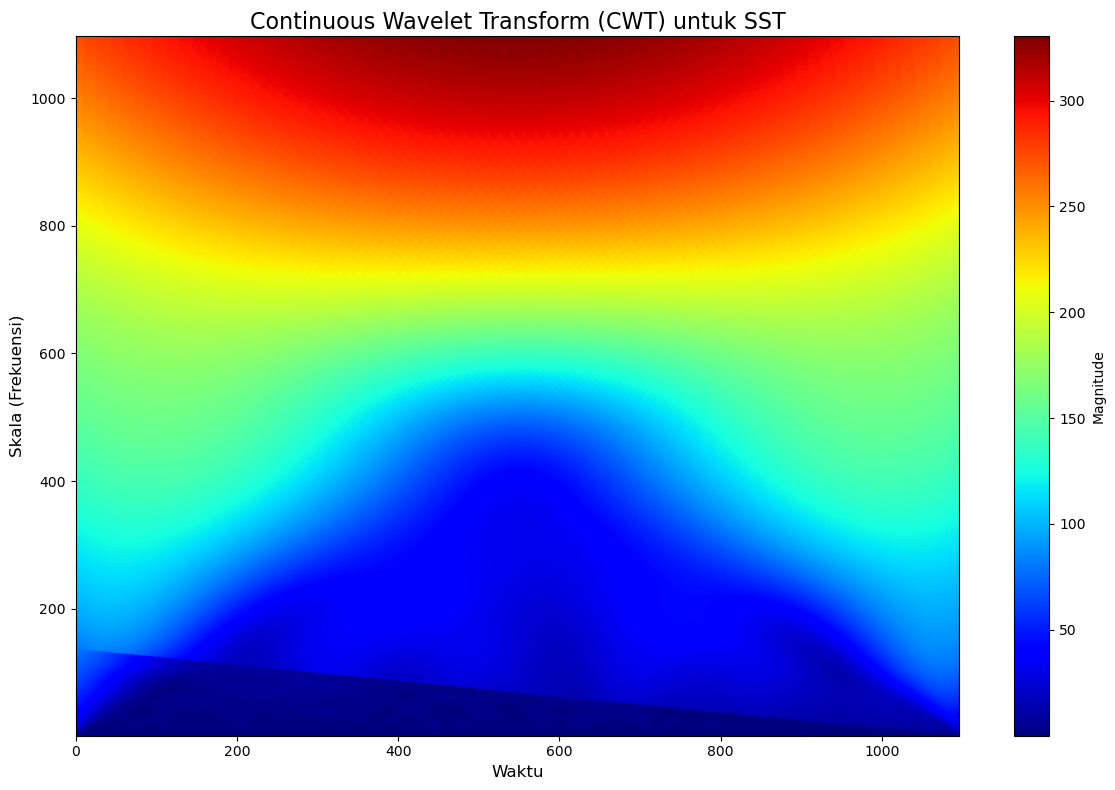

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import netCDF4
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import welch
import pywt


# Membaca data
data = pd.read_csv('data_banda.txt', delim_whitespace=True, parse_dates=['Date'], dayfirst=True)
print(data.dtypes)  # Memeriksa tipe data kolom

# Kolom yang akan diplot (kecuali kolom 'Tanggal')
columns_to_plot = data.columns[1:]

# Membuat plot
plt.figure(figsize=(12, 8))
for col in columns_to_plot:
    plt.plot(data['Date'], data[col], label=col, marker='-')

# Format X-Axis per bulan
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Locator per bulan
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format bulan dan tahun

# Detail grafik
plt.title('Plot Data per Kolom', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Nilai', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for col in columns_to_plot:
    data[f'{col}_MA'] = data[col].rolling(window=3).mean()

# Plot data asli dan moving average
plt.figure(figsize=(12, 8))
for col in columns_to_plot:
    plt.plot(data['Date'], data[col], label=f'{col} (Asli)', marker='o')
    plt.plot(data['Date'], data[f'{col}_MA'], label=f'{col} (Moving Average)', linestyle='--')

# Format X-Axis per bulan
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Detail grafik
plt.title('Data dan Moving Average per Kolom', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Nilai', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Menghitung korelasi antar kolom
correlation_matrix = data[columns_to_plot].corr()

# Menampilkan matriks korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Detail grafik
plt.title('Heatmap Korelasi Antar Variabel', fontsize=16)
plt.tight_layout()
plt.show()

# Membuat PCA
# Menyiapkan data untuk PCA (menggunakan hanya kolom numerik)
numerical_data = data[columns_to_plot]

# Menstandarisasi data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Melakukan PCA untuk 2 komponen utama
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Membuat DataFrame untuk hasil PCA
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Date'] = data['Date']

# Menampilkan hasil PCA
print(pca_df)

# Visualisasi PCA
plt.figure(figsize=(10, 6))
plt.plot(pca_df['Date'], pca_df['PC1'], label='PC1', marker='o')
plt.plot(pca_df['Date'], pca_df['PC2'], label='PC2', marker='x')

# Format X-Axis per bulan
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Detail grafik
plt.title('Komponen Utama (PCA)', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Nilai Komponen Utama', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # Langkah 7: Power Spectrum Density (PSD)
# Menghitung PSD untuk kolom pertama sebagai contoh
f, Pxx = welch(data['SST'], fs=86400, nperseg=256)

# Plot PSD
plt.figure(figsize=(10, 6))
plt.semilogy(f, Pxx)
plt.title('Power Spectrum Density (PSD) untuk SST', fontsize=16)
plt.xlabel('Frekuensi (Hz)', fontsize=12)
plt.ylabel('Kekuatan Spektrum (dB)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Langkah 8: Continuous Wavelet Transform (CWT)
# Menggunakan Continuous Wavelet Transform untuk analisis sinyal
wavelet = 'cmor'  # Continuous Morlet Wavelet
scales = np.arange(1, 1097)  # Rentang skala untuk wavelet
coefficients, frequencies = pywt.cwt(data['SST'], scales, wavelet)

# Plot CWT
plt.figure(figsize=(12, 8))
plt.imshow(np.abs(coefficients), extent=[0, len(data), 1, 1097], aspect='auto', cmap='jet', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform (CWT) untuk SST', fontsize=16)
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Skala (Frekuensi)', fontsize=12)
plt.tight_layout()
plt.show()
